Используя схемы переменных направлений и дробных шагов, решить двумерную начально-краевую задачу для дифференциального уравнения параболического типа. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением  $U(x, t)$. 

Исследовать зависимость погрешности от сеточных параметров  $\tau$, $h_x$, $h_y$.

$$ \frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2} + b \frac{\partial^2 u}{\partial y^2} + \sin{x} \sin{y} [\cos{\mu t} + (a+b) \sin{\mu t}] $$

$$ u(0, y, t) = 0 \\ u_x(\pi, y, t) = -\sin{y} \sin{\mu t}  \\ u(x, 0, t) = 0 \\  u_y(x, \pi, t) = -\sin{x} \sin{\mu t} \\ u(x, y, 0) = 0

В) $a = 1, b = 2, \mu = 1$

аналитическое решение $$ U(x, y, t) = \sin{x} \sin{y} \sin{\mu t} $$

In [47]:
import math
import typing
from typing import List
import matplotlib.pyplot as plt
import copy
import plotly.graph_objects as go
from functools import lru_cache

### Входные условия

In [2]:
x_left = 0
x_right = math.pi
y_left = 0
y_right = math.pi

a = 1
b = 2
mu = 1

In [3]:
def phi_1(y:float, t:float, mu:float=1) -> float:
    return 0

def phi_2(y:float, t:float, mu:float=1) -> float:
    return -math.sin(y) * math.sin(mu * t)


def phi_3(x:float, t:float, mu:float=1) -> float:
    return 0

def phi_4(x:float, t:float, mu:float=1) -> float:
    return -math.sin(x) * math.sin(mu * t)

def psi(x:float, y:float, mu:float=1) -> float:
    return 0

def f(x:float, y:float, t:float, mu:float=1, a:float=1, b:float=2) -> float:
    return math.sin(x) * math.sin(y) * (mu * math.cos(mu * t) + (a + b) * math.sin(mu * t))


def U(x:float, y:float, t:float, mu:float=1) -> float:
    return math.sin(x) * math.sin(y) * math.sin(mu * t)

def real_U(X:List[float], Y:List[float], T:List[float]) -> List[List[List[float]]]:
    U_true = [[[0] * len(X) for _ in range(len(Y))] for __ in range(len(T))]
    for i in range(len(T)):
        for k in range(len(Y)):
            for j in range(len(X)):
                U_true[i][k][j] = U(X[j], Y[k], T[i])
    return U_true

### Вспомогательные функиции

In [55]:
def local_error (U_my:list, U_true:list) -> float:
    return sum([abs(a - b) for a, b in zip(U_my, U_true)]) / len(U_my)

def get_error_array_with_h(N:list, x_left:float, x_right:float, y_left:float, y_right:float, a:float, b:float, 
                           mu:float, find_u:typing.Callable,t_end:float=1)  -> (list, list): # H, error
    

    H_x = [x_right/(n - 1) for n in N]
    H_y = [y_right/(n - 1) for n in N]
    ERROR_X = []
    ERROR_Y = []
    for n in N:
        XX, YY, TT, UU = find_u(x_left, x_right, y_left, y_right, a, b, mu, n_x=n, n_y=n, t_end=t_end)
        U_true = real_U(XX, YY, TT)
        t = len(TT) // 2
        y = len(YY) // 2
        x = len(XX) // 2
        ERROR_X.append(local_error(UU[t][y], U_true[t][y]))
        ERROR_Y.append(local_error(UU[t][:][x], U_true[t][:][x]))
    
    return H_x, H_y, ERROR_X, ERROR_Y

In [43]:
def h_error_plot(H:list, ERROR:list, s:str=' x') -> None:
    plt.plot(H, ERROR)
    plt.xlabel("h" + s)
    plt.ylabel("error")
    plt.show()

In [44]:
def frange(start:float, stop:float, step:float) -> float:
    while start < stop:
        yield start
        start += step

In [8]:
def get_y(y0:float, y_end:float, h:float) -> List[float]:
    return [i for i in frange(y0, y_end+h, h)]

def get_x(x_0:float, x_l:float, h:float) -> List[float]:
    return [i for i in frange(x_0, x_l+h, h)]

def get_t(t_0:float, t_end:float, h:float) -> List[float]:
    return [i for i in frange(t_0, t_end+h, h)]

In [9]:
def solve_PQ(A0:list, A1:list, A2:list, B:list) -> list:
    P = [-A2[0] / A1[0]]
    Q = [B[0] / A1[0]]
    for i in range(1, len(B)):

        P.append(-A2[i] / (A1[i] + A0[i] * P[i - 1]))
        Q.append((B[i] - A0[i] * Q[i - 1]) / (A1[i] + A0[i] * P[i - 1]))

    res = [Q[-1]]

    for i in range(len(B) - 2, -1, -1):
        res.append(P[i] * res[-1] + Q[i])

    return res[::-1]

In [10]:
def border_conds(U_values:List[List[float]], X:List[float], Y:List[float], T:List[float], mu:float, hx:float, hy:float) -> None:

    for i in range(len(Y)):
        for i in range(len(X)):
            U_values[0][i][j] = psi(X[j], Y[i], mu=mu)
    for k in range(len(T)):
        for i in range(len(X)):
            U_values[k][i][0] = phi_3(X[i], T[k], mu=mu)
            U_values[k][i][-1] = phi_4(X[i], T[k], mu=mu) * 2 * hy + U_values[k][i][-2]
        for j in range(len(Y)):
            U_values[k][0][j] = phi_1(Y[j], T[k], mu=mu)
            U_values[k][-1][j] = phi_2(Y[j], T[k], mu=mu) * 2 * hx + U_values[k][-2][j]

In [11]:
def initial_T(U_values:List[List[float]], X:List[float], Y:List[float], mu:float) -> None:
    for j in range(len(Y)):
        for i in range(len(X)):
            U_values[0][j][j] = psi(X[i], Y[j], mu=mu)

### Метод переменных направлений

$$ \frac{u^{k + \frac{1}{2}}_{i,j} - u^{k}_{i,j}}{\frac{\tau}{2}} = \frac{a}{h_1^2} \left (  u^{k + \frac{1}{2}}_{i+1, j} - 2  u^{k + \frac{1}{2}}_{i, j} +  u^{k + \frac{1}{2}}_{i-1, j}\right )  + \frac{b}{h_2^2} \left (  u^{k}_{i, j+1} - 2  u^{k}_{i, j} +  u^{k}_{i, j-1}\right ) + f^{k + \frac{1}{2}}_{i, j}$$
идём по j = $1 .. y_l - h_y$ по x неявно, по y явно


$$ \frac{u^{k + 1}_{i,j} - u^{k + \frac{1}{2}}_{i,j}}{\frac{\tau}{2}} = \frac{a}{h_1^2} \left (  u^{k + \frac{1}{2}}_{i+1, j} - 2  u^{k + \frac{1}{2}}_{i, j} +  u^{k + \frac{1}{2}}_{i-1, j}\right )  + \frac{b}{h_2^2} \left (  u^{k + 1}_{i, j+1} - 2  u^{k + 1}_{i, j} +  u^{k + 1}_{i, j-1}\right ) + f^{k + \frac{1}{2}}_{i, j}$$

идём по i = $1 .. x_l - h_x$ по x явно, по y неявно

In [251]:
def changing_directions(x_left:float, x_right:float, y_left:float, y_right:float, a:float, b:float, mu:float, 
                        n_x:float=10, n_y:float=10, t_end:float=1) -> (List[float], List[float], List[List[float]], List[List[float]]):

    t_right = t_end
    hx = x_right / (n_x - 1)
    hy = y_right / (n_y - 1)
    tau = (hx ** 2) / 2 / a**2 


    X = get_x(x_left, x_right, hx)
    Y = get_y(y_left, y_right, hy)
    T = get_t(0, t_right, tau)


    U_values = [[[0] * len(X) for _ in range(len(Y))] for __ in range(len(T))]
    sigma_x = (a * tau) / (hx ** 2)
    sigma_y = (b * tau) / (hy ** 2)
    
    initial_T(U_values, X, Y, mu)
    A0 = [0 for _ in range(len(X))]
    A1 = [0 for _ in range(len(X))]
    A2 = [0 for _ in range(len(X))]
    B = [0 for _ in range(len(X))]
    for k in range(1, len(T)):
        U_part = [[0 for _ in range(len(Y))] for _ in range(len(X))]

        for i in range(1, len(X) - 1):
            A1[0] = -1
            A2[0] = 0
            B[0] = phi_1(Y[0], T[k-1] + tau/2, mu=mu) 
            for j in range(1, len(Y) - 1):
                A0[j] = - sigma_x / 2
                A1[j] = 1 + sigma_x
                A2[j] = - sigma_x /2
                B[j] = f(X[i], Y[j], T[k-1] + tau/2, mu=mu) * tau / 2  + sigma_y * (U_values[k-1][j+1][i] - 2 * U_values[k-1][j][i] + U_values[k-1][j-1][i]) / 2 + U_values[k-1][j][i]
            A0[-1] = 0
            A1[-1] =  -1
            A2[-1] =  0
            B[-1] = phi_2(Y[-1], T[k-1] + tau/2, mu=mu) * 2 * hx + U_values[k-1][j][-2]

            tmp_res = solve_PQ(A0, A1, A2, B)            
            U_part[i] = tmp_res

        for j in range(1, len(Y) - 1):
            A1[0] = -1
            A2[0] = 0
            B[0] = phi_3(X[0], T[k], mu=mu)
            for i in range(1, len(X) - 1):
                A0[i] = - sigma_y / 2
                A1[i] = 1 + sigma_y
                A2[i] = - sigma_y / 2
                B[i] = f(X[i], Y[j], T[k-1] + tau/2, mu=mu) * tau / 2 + sigma_x * (U_part[i][j+1] - 2 * U_part[i][j] + U_part[i][j-1]) / 2 + U_part[i][j]
            A0[-1] = 0
            A1[-1] =  -1 
            B[-1] = phi_4(X[-1], T[k], mu=mu) * 2 * hy  + U_values[k-1][-2][i]


            tmp_res = solve_PQ(A0, A1, A2, B)
            U_values[k][j] = tmp_res

    return X, Y, T, U_values

Демонстрация работы

In [252]:
X, Y, T, UU = changing_directions(x_left, x_right, y_left, y_right, a, b, mu, n_x=20, n_y=20, t_end=1)
U_true = real_U(X, Y, T)

In [253]:
fig = go.Figure(data=[go.Surface(z=UU[len(T) // 2], x=X, y=Y)])
fig.show()


In [254]:
fig = go.Figure(data=[go.Surface(z=U_true[len(T) // 2], x=X, y=Y)])
fig.show()

In [255]:
fig = go.Figure(data=[go.Surface(z=UU[len(T) // 2], x=X, y=Y, colorscale='Reds', name='Метод переменных направлений'), go.Surface(z=U_true[len(T) // 2], x=X, y=Y, colorscale='Blues', name='Аналитическое решение')])
fig.update_layout(title='Метод переменных направлений - красный, Аналитическое решение - синий', showlegend=True)
fig.show()

Графики ошибок

In [256]:

N = [10, 15, 20, 30, 40]
H_X, H_Y, ERROR_X, ERROR_Y = get_error_array_with_h(N, x_left, x_right, y_left, y_right, a, b, mu, find_u=changing_directions, t_end=1)

In [206]:
H_X

[0.3490658503988659,
 0.2243994752564138,
 0.16534698176788384,
 0.10833078115826873,
 0.08055365778435367]

In [207]:
ERROR_X

[0.07236625212783165,
 0.0622447919538754,
 0.06187118397413298,
 0.06170876631815746,
 0.061597188172757465]

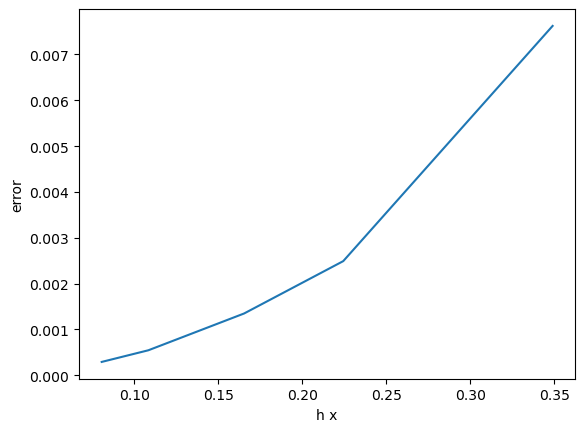

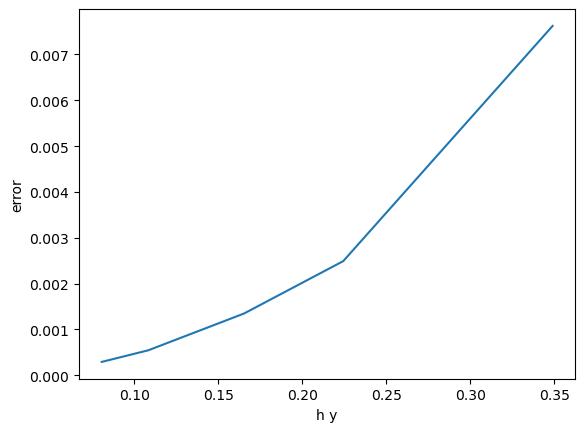

In [257]:
h_error_plot(H_X, ERROR_X)
h_error_plot(H_Y, ERROR_Y, s=' y')

In [175]:
T[1] - T[0]

0.013669812189874456

### Метод дробных шагов

Здесь слой $k + \frac{1}{2}$ становится "полностью вирутальныйм"

$$ \frac{u^{k + \frac{1}{2}}_{i,j} - u^{k}_{i,j}}{\tau} = \frac{a}{h_1^2} \left (  u^{k + \frac{1}{2}}_{i+1, j} - 2  u^{k + \frac{1}{2}}_{i, j} +  u^{k + \frac{1}{2}}_{i-1, j}\right ) + \frac{f^{k}_{i, j}}{2}$$

идём по j = $1 .. y_l - h_y$

$$ \frac{u^{k + 1}_{i,j} - u^{k + \frac{1}{2}}_{i,j}}{\tau} = \frac{b}{h_2^2} \left (  u^{k + 1}_{i, j+1} - 2  u^{k + 1}_{i, j} +  u^{k + 1}_{i, j-1}\right ) + \frac{f^{k + 1}_{i, j}}{2}$$

идём по i = $1 .. x_l - h_x$ по x явно, по y неявно

In [61]:
def partial_steps(x_left:float, x_right:float, y_left:float, y_right:float, a:float, b:float, mu:float, 
                        n_x:float=10, n_y:float=10, t_end:float=1) -> (List[float], List[float], List[List[float]], List[List[float]]):
    t_right = t_end
    hx = x_right / (n_x - 1)
    hy = y_right / (n_y - 1)
    tau = (hx**2) / 2 / a**2 


    X = get_x(x_left, x_right, hx)
    Y = get_y(y_left, y_right, hy)
    T = get_t(0, t_right, tau)


    U_values = [[[0] * len(X) for _ in range(len(Y))] for __ in range(len(T))]
    sigma_x = (a * tau) / (hx ** 2)
    sigma_y = (b * tau) / (hy ** 2)
    
    initial_T(U_values, X, Y, mu)
    A0 = [0 for _ in range(len(X))]
    A1 = [0 for _ in range(len(X))]
    A2 = [0 for _ in range(len(X))]
    B = [0 for _ in range(len(X))]
    for k in range(1, len(T)):
        U_part = [[0 for _ in range(len(Y))] for _ in range(len(X))]
        t_part = T[k-1] + tau/2

        for i in range(1, len(X) - 1):
            A1[0] = -1
            A2[0] = 0
            B[0] = phi_1(Y[0], t_part, mu=mu) 
            for j in range(1, len(Y) - 1):
                A0[j] = - sigma_x
                A1[j] = 1 + 2 * sigma_x
                A2[j] = - sigma_x
                B[j] = f(X[i], Y[j], T[k-1], mu=mu) * tau / 2  + U_values[k-1][j][i]
            A0[-1] = 0
            A1[-1] =  -1
            A2[-1] =  0
            B[-1] = phi_2(Y[-1], t_part, mu=mu) * 2 * hx + U_values[k][j][-2]  ### тут надо подумать что брать U_values

            tmp_res = solve_PQ(A0, A1, A2, B)            
            U_part[i] = tmp_res

        t_part += tau/2
        for j in range(1, len(Y) - 1):
            A1[0] = -1
            A2[0] = 0
            B[0] = phi_3(X[0], t_part, mu=mu)
            for i in range(1, len(X) - 1):
                A0[i] = - sigma_y
                A1[i] = 1 + 2 * sigma_y
                A2[i] = - sigma_y
                B[i] = f(X[i], Y[j], T[k], mu=mu) * tau / 2 + U_part[i][j]
            A0[-1] = 0
            A1[-1] =  -1 
            B[-1] = phi_4(X[-1], t_part, mu=mu) * 2 * hy  + U_values[k][-2][i]# аналогично предидущему варианту с шраниццами
            tmp_res = solve_PQ(A0, A1, A2, B) # езультат, заносим в U_values


            U_values[k][j] = tmp_res

    return X, Y, T, U_values


Демонстрация работы

In [138]:
XX, YY, TT, UUU = partial_steps(x_left, x_right, y_left, y_right, a, b, mu, n_x=20, n_y=20, t_end=1)
U_true2 = real_U(XX, YY, TT)

In [139]:
fig = go.Figure(data=[go.Surface(z=UUU[len(T) // 2], x=XX, y=YY)])
fig.show()

In [140]:
fig = go.Figure(data=[go.Surface(z=U_true2[len(T) // 2], x=XX, y=YY)])
fig.show()

In [63]:
fig = go.Figure(data=[go.Surface(z=UUU[len(TT) // 2], x=XX, y=YY, colorscale='Reds', name='Метод дробных шагов'), go.Surface(z=U_true2[len(TT) // 2], x=XX, y=YY, colorscale='Blues', name='Аналитическое решение')])
fig.update_layout(title='Метод дробных шагов - красный, Аналитическое решение - синий', showlegend=True)
fig.show()

Гафик ошибок

In [62]:
N = [10, 15, 20, 30, 40]
H_X, H_Y, ERROR_X, ERROR_Y = get_error_array_with_h(N, x_left, x_right, y_left, y_right, a, b, mu, find_u=partial_steps)

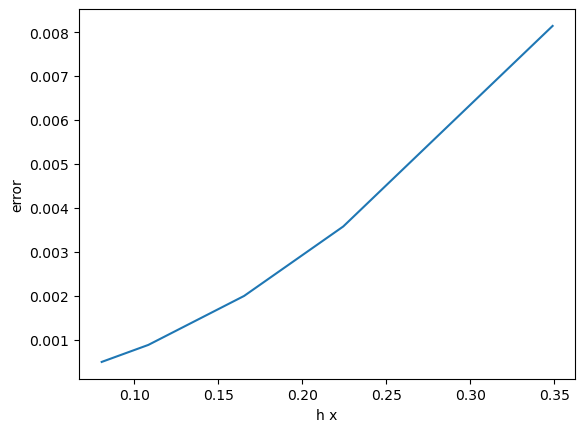

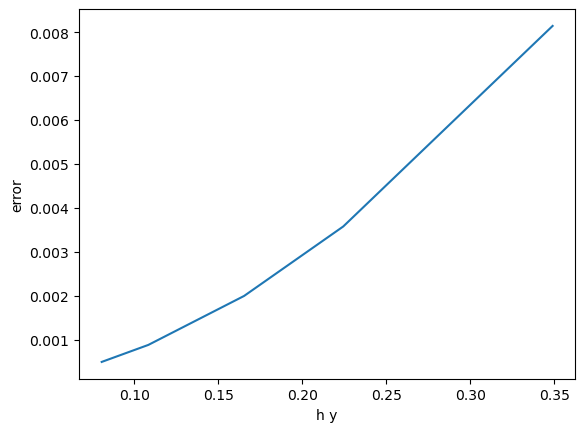

In [63]:
h_error_plot(H_X, ERROR_X)
h_error_plot(H_Y, ERROR_Y, s=' y')